In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import math

In [45]:
cameraOrigin = np.array([0,0,-3])
cameraLookAt = np.array([0,0,0])
cameraUp = np.array([0,1,0])
fovDegrees = 45
width = 50
height = 50
nearClip = 0.1
farClip = 10
print("camera origin:", cameraOrigin)
print("camera target:", cameraLookAt)
print("camera up:    ", cameraUp)

nearClip = -nearClip
farClip = -farClip

fovRadians = np.deg2rad(fovDegrees)
aspectRatio = width / height;
mFrustumTop = nearClip * np.tan(0.5 * fovRadians);
mFrustumBottom = -mFrustumTop;
mFrustumRight = mFrustumTop * aspectRatio;
mFrustumLeft = -mFrustumRight;
print("fovRadians:", fovRadians)
print("frustumTop", mFrustumTop)
print("frustumBottom", mFrustumBottom)
print("frustumRight", mFrustumRight)
print("frustumLeft", mFrustumLeft)

projMatrix = np.zeros((4,4))
projMatrix[0,0] = 2.0 * nearClip / (mFrustumRight - mFrustumLeft);
projMatrix[1,0] = 0.0;
projMatrix[2,0] = (mFrustumRight + mFrustumLeft) / (mFrustumRight - mFrustumLeft);
projMatrix[3,0] = 0.0;
projMatrix[0,1] = 0.0;
projMatrix[1,1] = 2.0 * nearClip / (mFrustumTop - mFrustumBottom);
projMatrix[2,1] = (mFrustumTop + mFrustumBottom) / (mFrustumTop - mFrustumBottom);
projMatrix[3,1] = 0.0;
projMatrix[0,2] = 0.0;
projMatrix[1,2] = 0.0;
projMatrix[2,2] = -(farClip + nearClip) / (farClip - nearClip);
projMatrix[3,2] = -2.0 * farClip * nearClip / (farClip - nearClip);
projMatrix[0,3] = 0.0;
projMatrix[1,3] = 0.0;
projMatrix[2,3] = -1.0;
projMatrix[3,3] = 0.0;
projMatrix = projMatrix.transpose()
print("Projection Matrix:\n", projMatrix, sep='')

invProjMatrix = np.linalg.inv(projMatrix)
print("Inverse Projection Matrix:\n", invProjMatrix, sep='')

def printVector(mat, vec):
    vec = np.array([vec+[1]]).transpose()
    res = np.matmul(mat, vec)
    res = res / res[3]
    print("[% 5.3f, % 5.3f, % 5.3f] -> [% 7.5f, % 7.5f, % 7.5f]"%(vec[0], vec[1], vec[2], res[0], res[1], res[2]))

print()
print("Screen to eye:")
printVector(invProjMatrix, [0,0,-1])
printVector(invProjMatrix, [0,0,0])
printVector(invProjMatrix, [0,0,1])
printVector(invProjMatrix, [0,0,2])

def normalize(v): 
    return v / np.linalg.norm(v)
def length2(v):
    return np.dot(v,v)
def alignZAxisWithTarget(targetDir, upDir):
    # Ensure that the target direction is non-zero.
    if length2(targetDir) == 0:
        targetDir = np.array([0, 0, 1]);

    # Ensure that the up direction is non-zero.
    if length2(upDir) == 0:
        upDir = np.array([0, 1, 0]);

    # Check for degeneracies.  If the upDir and targetDir are parallel 
    # or opposite, then compute a new, arbitrary up direction that is
    # not parallel or opposite to the targetDir.
    if length2(np.cross(upDir, targetDir)) == 0:
        upDir = np.cross(targetDir, np.array([1, 0, 0]));
        if length2(upDir) == 0:
            upDir = cross(targetDir, np.array([0, 0, 1]));

    # Compute the x-, y-, and z-axis vectors of the new coordinate system.
    targetPerpDir = np.cross(upDir, targetDir);
    targetUpDir = np.cross(targetDir, targetPerpDir);

    # Rotate the x-axis into targetPerpDir (row 0),
    # rotate the y-axis into targetUpDir   (row 1),
    # rotate the z-axis into targetDir     (row 2).
    targetPerpDir = normalize(targetPerpDir);
    targetUpDir = normalize(targetUpDir);
    targetDir = normalize(targetDir);
    result = np.array(
        [
            [targetPerpDir[0], targetPerpDir[1], targetPerpDir[2], 0],
            [targetUpDir[0], targetUpDir[1], targetUpDir[2], 0],
            [targetDir[0], targetDir[1], targetDir[2], 0],
            [0,0,0,1]
        ]
    )
    return result;

def toQuat(m):
    fourXSquaredMinus1 = m[0,0] - m[1,1] - m[2,2];
    fourYSquaredMinus1 = m[1,1] - m[0,0] - m[2,2];
    fourZSquaredMinus1 = m[2,2] - m[0,0] - m[1,1];
    fourWSquaredMinus1 = m[0,0] + m[1,1] + m[2,2];

    biggestIndex = 0;
    fourBiggestSquaredMinus1 = fourWSquaredMinus1;
    if fourXSquaredMinus1 > fourBiggestSquaredMinus1:
        fourBiggestSquaredMinus1 = fourXSquaredMinus1;
        biggestIndex = 1;
    if fourYSquaredMinus1 > fourBiggestSquaredMinus1:
        fourBiggestSquaredMinus1 = fourYSquaredMinus1;
        biggestIndex = 2;
    if fourZSquaredMinus1 > fourBiggestSquaredMinus1:
        fourBiggestSquaredMinus1 = fourZSquaredMinus1;
        biggestIndex = 3;

    biggestVal = np.sqrt(fourBiggestSquaredMinus1 + 1) * 0.5;
    mult = 0.25 / biggestVal;

    if biggestIndex == 0:
        return np.array([biggestVal, (m[1,2] - m[2,1]) * mult, (m[2,0] - m[0,2]) * mult, (m[0,1] - m[1,0]) * mult]);
    elif biggestIndex == 1:
        return np.array([(m[1,2] - m[2,1]) * mult, biggestVal, (m[0,1] + m[1,0]) * mult, (m[2,0] + m[0,2]) * mult]);
    elif biggestIndex == 2:
        return np.array([(m[2,0] - m[0,2]) * mult, (m[0,1] + m[1,0]) * mult, biggestVal, (m[1,2] + m[2,1]) * mult]);
    elif biggestIndex == 3:
        return np.array([(m[0,1] - m[1,0]) * mult, (m[2,0] + m[0,2]) * mult, (m[1,2] + m[2,1]) * mult, biggestVal]);

def rotate(quat, v):
    qv = quat[0:3]
    uv = np.cross(qv, v)
    uuv = np.cross(qv, uv)
    return v + ((uv * quat[3])+uuv)*2
    
print()
viewDirection = normalize(cameraLookAt - cameraOrigin);
alignMat = alignZAxisWithTarget(-viewDirection, cameraUp)
print("Align-Matrix:\n", alignMat, sep='')
orientation = toQuat(alignMat);
mW = -normalize(viewDirection);
mU = rotate(orientation, np.array([1, 0, 0]));
mV = rotate(orientation, np.array([0, 1, 0]));
d = np.array([-np.dot(cameraOrigin, mU), -np.dot(cameraOrigin, mV), -np.dot(cameraOrigin, mW)]);
print("viewDirection", viewDirection)
print("orientation", orientation)
print("mW", mW)
print("mU", mU)
print("mV", mV)
print("d", d)

viewMatrix = np.zeros((4,4))
viewMatrix[0,0] = mU[0]; viewMatrix[1,0] = mU[1]; viewMatrix[2,0] = mU[2]; viewMatrix[3,0] = d[0];
viewMatrix[0,1] = mV[0]; viewMatrix[1,1] = mV[1]; viewMatrix[2,1] = mV[2]; viewMatrix[3,1] = d[1];
viewMatrix[0,2] = mW[0]; viewMatrix[1,2] = mW[1]; viewMatrix[2,2] = mW[2]; viewMatrix[3,2] = d[2];
viewMatrix[0,3] = 0.0; viewMatrix[1,3] = 0.0; viewMatrix[2,3] = 0.0; viewMatrix[3,3] = 1.0;
print("View Matrix:\n", viewMatrix, sep='')

print()
print("World to eye:")
printVector(viewMatrix, [-1,-1,-1])
printVector(viewMatrix, [+1,-1,-1])
printVector(viewMatrix, [-1,+1,-1])
printVector(viewMatrix, [+1,+1,-1])
printVector(viewMatrix, [-1,-1,+1])
printVector(viewMatrix, [+1,-1,+1])
printVector(viewMatrix, [-1,+1,+1])
printVector(viewMatrix, [+1,+1,+1])

viewProjMatrix = np.matmul(projMatrix, viewMatrix)

print()
print("World to screen:")
printVector(viewProjMatrix, [-1,-1,-1])
printVector(viewProjMatrix, [+1,-1,-1])
printVector(viewProjMatrix, [-1,+1,-1])
printVector(viewProjMatrix, [+1,+1,-1])
printVector(viewProjMatrix, [-1,-1,+1])
printVector(viewProjMatrix, [+1,-1,+1])
printVector(viewProjMatrix, [-1,+1,+1])
printVector(viewProjMatrix, [+1,+1,+1])

invViewProjMatrix = np.linalg.inv(viewProjMatrix)
print("Inverse View-Projection-Matrix:")
print(invViewProjMatrix)

def printRay(mat, x, y):
    vec1 = np.array([x, y, -1, 1]).transpose()
    res1 = np.matmul(mat, vec1)
    res1 = res1 / res1[3]
    vec2 = np.array([x, y, +1, 1]).transpose()
    res2 = np.matmul(mat, vec2)
    res2 = res2 / res2[3]
    rd = normalize(res2[0:3]-res1[0:3])
    print("[% 5.3f, % 5.3f] -> [% 7.5f, % 7.5f, % 7.5f]"%(x, y, rd[0], rd[1], rd[2]))
print()
print("Screen to ray:")
printRay(invViewProjMatrix, -1, -1)
printRay(invViewProjMatrix, -1, +1)
printRay(invViewProjMatrix, +1, -1)
printRay(invViewProjMatrix, +1, +1)

camera origin: [ 0  0 -3]
camera target: [0 0 0]
camera up:     [0 1 0]
fovRadians: 0.7853981633974483
frustumTop -0.041421356237309505
frustumBottom 0.041421356237309505
frustumRight -0.041421356237309505
frustumLeft 0.041421356237309505
Projection Matrix:
[[ 2.41421356  0.         -0.          0.        ]
 [ 0.          2.41421356 -0.          0.        ]
 [ 0.          0.         -1.02020202  0.2020202 ]
 [ 0.          0.         -1.          0.        ]]
Inverse Projection Matrix:
[[ 4.14213562e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.14213562e-01  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  1.74915088e-17 -1.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  4.95000000e+00 -5.05000000e+00]]

Screen to eye:
[ 0.000,  0.000, -1.000] -> [-0.00000, -0.00000,  0.10000]
[ 0.000,  0.000,  0.000] -> [-0.00000, -0.00000,  0.19802]
[ 0.000,  0.000,  1.000] -> [-0.00000, -0.00000,  10.00000]
[ 0.000,  0.000,  2.000] -> [ 0.00000,  0.00000

In [46]:
print("Import library")
os.chdir(os.path.join(os.getcwd(), "../bin"))
torch.ops.load_library("./Renderer.dll")

Import library


In [47]:
print("Load volume from xyz")
torch.ops.renderer.load_volume_from_xyz("../../isosurface-super-resolution-data/clouds/inputXYZ/cloud-049.xyz")

Load volume from xyz


1

In [48]:
def plot_output(output):
    #print("Shape:", output.shape)
    output_np = output.cpu().numpy()

    #for i in range(output.shape[0]):
    #    print("Channel ",i,": min=",np.min(output_np[i,:,:]),", max=",np.max(output_np[i,:,:]),
    #            sep='')

    fix, ax = plt.subplots(1,3);
    ax[0].imshow(output_np[0,:,:].transpose(1,0)); ax[0].set_title("Mask")
    ax[1].imshow((output_np[1:4,:,:]*0.5+0.5).transpose(2,1,0)); ax[1].set_title("Normal")
    ax[2].imshow(output_np[4,:,:].transpose(1,0)); ax[2].set_title("Depth")
    plt.show()

Set render settings
Render
Show output


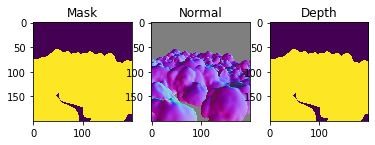

In [57]:
print("Set render settings")
set_params = torch.ops.renderer.set_renderer_parameter
set_params("isovalue", "0.5")
set_params("resolution", "200,200")
set_params("cameraUp", "1,0,0")
set_params("cameraOrigin", "-0.5,0.2,-0.8")
set_params("fov", "30")

print("Render")
output = torch.ops.renderer.render()

print("Show output")
plot_output(output)

In [ ]:
print("Close volume")
torch.ops.renderer.close_volume()